In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os, gc, random, time, timm, math
import pandas as pd
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 1 GPU(s)


In [2]:
print(os.getcwd())

/home/shiyi/kaggle_hms


In [3]:
class config:
    AMP = True
    BATCH_SIZE = 16
    EPOCHS = 6
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 2
    MAX_GRAD_NORM = 1e7
    MODEL = "tf_efficientnet_b2" #"tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 50
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    SAMPLE = 5
    USE_CHECKPOINT = True

# class paths:
#     OUTPUT_DIR = "/kaggle/working/"
#     PRE_LOADED_EEGS = '/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy'
#     PRE_LOADED_SPECTOGRAMS = '/kaggle/input/brain-spectrograms/specs.npy'
#     TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
#     TRAIN_EEGS = "/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/"
#     TRAIN_SPECTOGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"
#     TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
#     TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
#     TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"


class LocalPaths:
    OUTPUT_DIR = "./outputs/"
    PRE_LOADED_EEGS = './inputs/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTOGRAMS = './inputs/brain-spectrograms/specs.npy'
    TRAIN_CSV = "./inputs/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = " ./inputs/hms-harmful-brain-activity-classification/train_eegs/"
    TRAIN_SPECTOGRAMS = "./inputs/hms-harmful-brain-activity-classification/train_spectrograms/"
    TEST_CSV = "./inputs/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/test_spectrograms/"
    TEST_EEGS = "./inputs/hms-harmful-brain-activity-classification/test_eegs/"

paths = LocalPaths

In [5]:
if config.USE_CHECKPOINT:
    # model_weights = [x for x in glob("/kaggle/input/hms-5125123-b2/*.pth")]
    model_weights = [x for x in glob("./inputs/hms-5125123-b2/*.pth")]
    for i in model_weights:
        print(i)

./inputs/hms-5125123-b2/tf_efficientnet_b2_fold_0_best (1).pth
./inputs/hms-5125123-b2/tf_efficientnet_b2_fold_2_best (1).pth
./inputs/hms-5125123-b2/tf_efficientnet_b2_fold_3_best (1).pth
./inputs/hms-5125123-b2/tf_efficientnet_b2_fold_1_best (1).pth
./inputs/hms-5125123-b2/tf_efficientnet_b2_fold_4_best (1).pth


# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    

target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data \& Preprocess</b><a class='anchor' id='load_data'></a> [↑](#top) 

The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [7]:
from scipy.stats import entropy
from scipy.special import rel_entr
def cal_entropy(row, tgt_list):
    uniform_list = [1/6 for i in range(6)]
    return sum(rel_entr(uniform_list, row[tgt_list].astype('float32').values + 1e-5))
def get_non_overlap(df_csv, targets):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # same results as Chris's notebook

    tgt_list = targets.tolist()

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
    }

    for t in tgt_list:
        agg_dict[t] = 'sum'

    agg_dict['expert_consensus'] = 'first'

    train = df_csv.groupby('eeg_id').agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id'] + tgt_list + ['target']
    train = train.reset_index(drop=False)

    train[tgt_list] = train[tgt_list].div(train[tgt_list].sum(axis=1), axis='index')

    train["entropy"] = train.apply(cal_entropy, args=(tgt_list,), axis=1)
    return train

In [8]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train cataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")

df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [9]:
train_df = get_non_overlap(df, label_cols)

train_df.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,entropy
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.584192
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,4.870032
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,7.802343
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,7.802343
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,7.802343


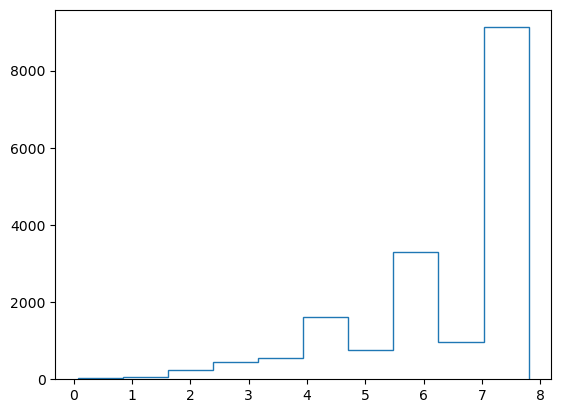

In [10]:
counts, bins = np.histogram(train_df["entropy"],)
plt.stairs(counts, bins)

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

Our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811

In [11]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        df: pd.DataFrame, 
        config,
        specs: Dict[int, np.ndarray],
        eeg_specs: Dict[int, np.ndarray],
        augment: bool = False,
        mode: str = 'train',
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE
        self.augment = augment
        self.mode = mode
        self.spectograms = specs
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
            
        for region in range(4): #spectrogram_id
            img = self.spectograms[row['spectrogram_id']][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.eeg_id]
            X[:, :, 4:] = img
                
            if self.mode != 'test':
                y = row[label_cols].values.astype(np.float32)
            
        return X, y
    
    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

We will be using the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.

In [12]:
class CustomModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(CustomModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = timm.create_model(
            config.MODEL,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.2,
        )
        
        self.preprocess = torch.nn.Conv2d(4, 3, 1, bias=True)
        
        if config.FREEZE:
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:config.NUM_FROZEN_LAYERS]):
                param.requires_grad = False

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )

    def __reshape_input(self, x):
        # input size: [batch * 128 * 256 * 8]
        
        # --> 256*256*4
        # spectograms = x[:, :, :, 0:4]  
        # eegs = x[:, :, :, 4:8] 
        # x = torch.cat([spectograms, eegs], dim=1)
        # x = x.permute(0, 3, 1, 2)
        
        ## --> 512*512*3
        spectograms = torch.cat([x[:, :, :, i:i+1] for i in range(4)], dim=1) 
        eegs = torch.cat([x[:, :, :, i:i+1] for i in range(4,8)], dim=1)
        x = torch.cat([spectograms, eegs], dim=2)
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        
        return x
    
    def forward(self, x):
        x = self.__reshape_input(x)
        # x = self.preprocess(x)
        x = self.features(x)
        x = self.custom_layers(x)
        return x

# <b><span style='color:#F1A424'>|</span> Train </b><a class='anchor' id='load_data'></a> [↑](#top) 

In [13]:
train_mode = True

### <b><span style='color:#F1A424'>Read Train Spectrograms</span></b>


First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

The resulting `all_spectograms` dictionary contains `spectogram_id` as keys (`int` keys) and the values are the spectogram sequences (as 2-dimensional `np.array`) of shape `(timesteps, 400)`.

Each spectogram is a parquet file. This parquet, when converted to a pandas dataframe, results in a dataframe of shape `(time_steps, 401)`. First column is the `time` column and the remaining 400 columns are the recordings. There are 400 columns because there are, respectively, 100 rows associated to the 4 recording regions of the EEG electrodes: `LL`, `RL`, `LP`, `RP`. Column names also include the frequency in heartz.

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.

There are 11138 spectrogram parquets


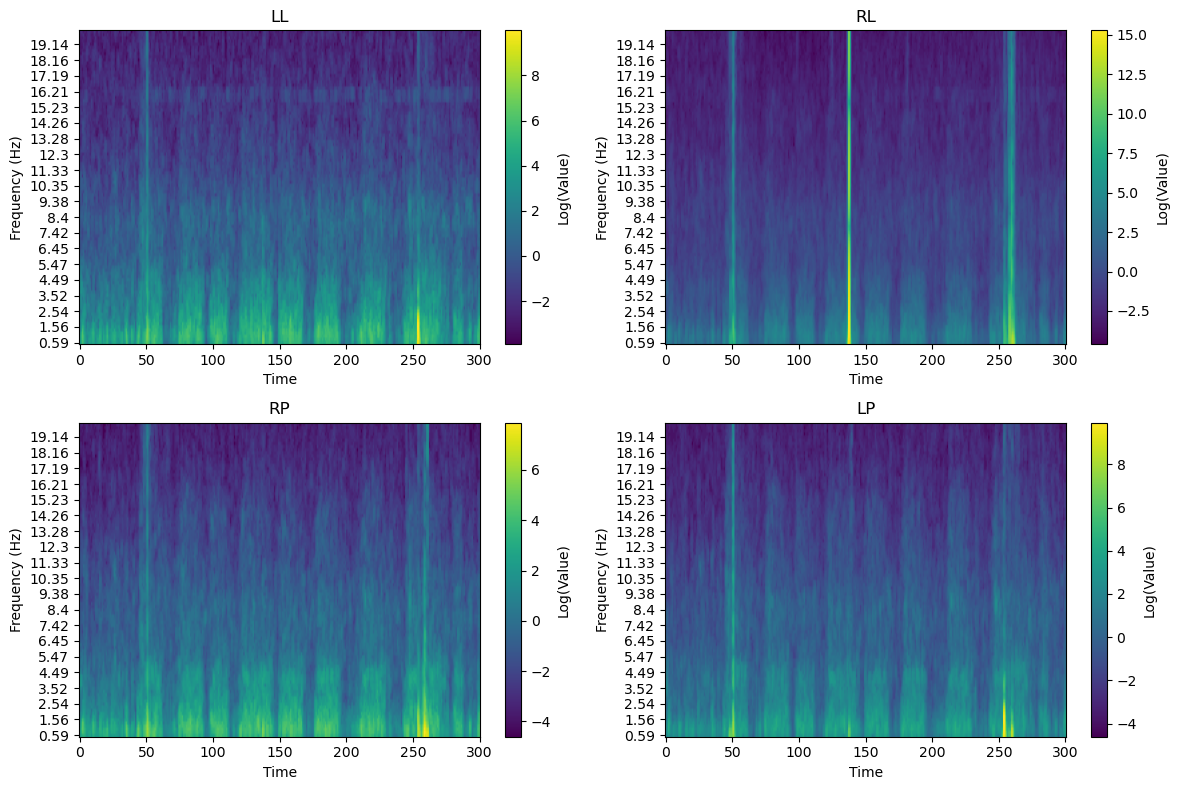

There are 0 EEG spectograms
CPU times: user 1.22 s, sys: 3.33 s, total: 4.54 s
Wall time: 4.5 s


In [14]:
%%time

if train_mode:

    READ_SPEC_FILES = False
    READ_EEG_SPEC_FILES = False

    paths_spectograms = glob(paths.TRAIN_SPECTOGRAMS + "*.parquet")
    print(f'There are {len(paths_spectograms)} spectrogram parquets')

    if READ_SPEC_FILES:    
        all_spectrograms = {}
        for file_path in tqdm(paths_spectograms):
            aux = pd.read_parquet(file_path)
            name = int(file_path.split("/")[-1].split('.')[0])
            all_spectrograms[name] = aux.iloc[:,1:].values
            del aux
    else:
        all_spectrograms = np.load(paths.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()

    if config.VISUALIZE:
        idx = np.random.randint(0,len(paths_spectograms))
        spectrogram_path = paths_spectograms[idx]
        plot_spectrogram(spectrogram_path)

    paths_eegs = glob(paths.TRAIN_EEGS + "*.npy")
    print(f'There are {len(paths_eegs)} EEG spectograms')

    if READ_EEG_SPEC_FILES:
        all_eegs = {}
        for file_path in tqdm(paths_eegs):
            eeg_id = file_path.split("/")[-1].split(".")[0]
            eeg_spectogram = np.load(file_path)
            all_eegs[eeg_id] = eeg_spectogram
    else:
        all_eegs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()

In [15]:
# if train_mode:
    
#     train_dataset = CustomDataset(train_df, config, all_spectrograms, all_eegs, mode="train")
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=config.BATCH_SIZE,
#         shuffle=False,
#         num_workers=config.NUM_WORKERS, 
#         pin_memory=True, 
#         drop_last=True
#     )

#     if config.VISUALIZE:
#         X, y = train_dataset[0]
#         print(f"X shape: {X.shape}")
#         print(f"y shape: {y.shape}")

#         ROWS = 2
#         COLS = 3
#         for (X, y) in train_loader:
#             plt.figure(figsize=(20,8))
#             for row in range(ROWS):
#                 for col in range(COLS):
#                     plt.subplot(ROWS, COLS, row*COLS + col+1)
#                     t = y[row*COLS + col]
#                     img = X[row*COLS + col, :, :, 0]
#                     mn = img.flatten().min()
#                     mx = img.flatten().max()
#                     img = (img-mn)/(mx-mn)
#                     plt.imshow(img)
#                     tars = f'[{t[0]:0.2f}'
#                     for s in t[1:]:
#                         tars += f', {s:0.2f}'
#                     eeg = train_df.eeg_id.values[row*config.BATCH_SIZE + row*COLS + col]
#                     plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
#                     plt.yticks([])
#                     plt.ylabel('Frequencies (Hz)',size=14)
#                     plt.xlabel('Time (sec)',size=16)
#             plt.show()
#             break

In [16]:
def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() 
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, (X, y) in enumerate(tqdm_train_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds = model(X) 
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                remain = timeSince(start, float(step+1)/len(train_loader))
                lr=scheduler.get_last_lr()[0]
                info = f"Epoch: [{epoch+1}][{step}/{len(train_loader)}]"
                info += f"Elapsed {remain:s} Loss: {losses.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.8f}"
                print(info)

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, (X, y) in enumerate(tqdm_valid_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = y_preds
            preds.append(y_preds.to('cpu').numpy())
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                remain=timeSince(start, float(step+1)/len(valid_loader))
                info = f"EVAL: [{step}/{len(valid_loader)}] Elapsed {remain:s} Loss: {losses.avg:.4f}"
                print(info)
                
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

In [17]:
from torch.optim.lr_scheduler import OneCycleLR

def train_loop(df, fold, all_specs, all_eegs, model_postfix=None):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    if config.USE_CHECKPOINT:
        train_folds = train_folds[train_folds["entropy"] < 5.5]
        # valid_folds = valid_folds[valid_folds["entropy"] < 5.5]
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, config, all_specs, all_eegs, mode="train", augment=True)
    valid_dataset = CustomDataset(valid_folds, config, all_specs, all_eegs, mode="train", augment=False)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel(config)
    if config.USE_CHECKPOINT:
        checkpoint = torch.load(model_weights[fold])
        model.load_state_dict(checkpoint["model"])
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    
    if not model_postfix:
        save_model = paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_f{fold}_best.pth"
    else:
        save_model = paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_f{fold}_{model_postfix}.pth"
        
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save(
                {'model': model.state_dict(), 'predictions': predictions},
                save_model
            )

    predictions = torch.load(save_model, map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [18]:
def train_loop_full_data(df):
    train_dataset = CustomDataset(df, config, mode="train", augment=True)
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    model = CustomModel(config)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )
    criterion = nn.KLDivLoss(reduction="batchmean")
    best_loss = np.inf
    for epoch in range(config.EPOCHS):
        start_time = time.time()
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        elapsed = time.time() - start_time
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  time: {elapsed:.0f}s')
        torch.save(
            {'model': model.state_dict()},
            paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_epoch_{epoch}.pth")
    torch.cuda.empty_cache()
    gc.collect()
    return _

In [19]:
import torch.nn.functional as F

def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if train_mode: 
    from sklearn.model_selection import KFold, GroupKFold
    if not config.TRAIN_FULL_DATA:

        gkf = GroupKFold(n_splits=config.FOLDS)
        for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
            train_df.loc[valid_index, "fold"] = int(fold)

        display(train_df.groupby('fold').size()), sep()
        display(train_df.head())

        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold in [0, 1, 2, 3, 4]:
                _oof_df = train_loop(train_df, fold, all_spectrograms, all_eegs)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
                print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV: {get_result(oof_df)} ==========")
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
    else:
        train_loop_full_data(train_df)

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,entropy,fold
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.584192,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,4.870032,2.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,7.802343,4.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,7.802343,2.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,7.802343,2.0


========== Fold: 0 training ==========
Train:   1%|          | 2/176 [00:01<01:39,  1.75train_batch/s]

Epoch: [1][0/176]Elapsed 0m 1s (remain 3m 11s) Loss: 0.2033 Grad: 56756.6523 LR: 0.00000400


Train:  30%|██▉       | 52/176 [00:08<00:19,  6.31train_batch/s]

Epoch: [1][50/176]Elapsed 0m 8s (remain 0m 20s) Loss: 0.2319 Grad: 58571.3281 LR: 0.00001691


Train:  58%|█████▊    | 102/176 [00:15<00:11,  6.28train_batch/s]

Epoch: [1][100/176]Elapsed 0m 15s (remain 0m 11s) Loss: 0.2199 Grad: 48661.6992 LR: 0.00004869


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.33train_batch/s]

Epoch: [1][150/176]Elapsed 0m 22s (remain 0m 3s) Loss: 0.2061 Grad: 31694.4238 LR: 0.00008225


Train: 100%|██████████| 176/176 [00:26<00:00,  6.69train_batch/s]


Epoch: [1][175/176]Elapsed 0m 26s (remain 0m 0s) Loss: 0.1984 Grad: 57738.0195 LR: 0.00009416


Validation:   0%|          | 1/214 [00:00<00:23,  9.06valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.4025


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3462


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.35valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3490


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.37valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3429


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.36valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3431


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.35valid_batch/s]
Epoch 1 - avg_train_loss: 0.1984  avg_val_loss: 0.3433  time: 49s
Epoch 1 - Save Best Loss: 0.3433 Model


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3433


Train:   1%|          | 2/176 [00:00<00:29,  5.87train_batch/s]

Epoch: [2][0/176]Elapsed 0m 0s (remain 0m 20s) Loss: 0.1434 Grad: 41704.1250 LR: 0.00009416


Train:  30%|██▉       | 52/176 [00:07<00:19,  6.29train_batch/s]

Epoch: [2][50/176]Elapsed 0m 7s (remain 0m 18s) Loss: 0.1577 Grad: 42545.1289 LR: 0.00009998


Train:  58%|█████▊    | 102/176 [00:14<00:11,  6.28train_batch/s]

Epoch: [2][100/176]Elapsed 0m 14s (remain 0m 10s) Loss: 0.1501 Grad: 26580.7305 LR: 0.00009970


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.28train_batch/s]

Epoch: [2][150/176]Elapsed 0m 21s (remain 0m 3s) Loss: 0.1437 Grad: 20953.3613 LR: 0.00009907


Train: 100%|██████████| 176/176 [00:25<00:00,  6.88train_batch/s]


Epoch: [2][175/176]Elapsed 0m 25s (remain 0m 0s) Loss: 0.1405 Grad: 41713.6680 LR: 0.00009861


Validation:   0%|          | 1/214 [00:00<00:22,  9.34valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.3895


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.39valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3308


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.32valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3343


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.35valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3285


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.38valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3282


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.37valid_batch/s]
Epoch 2 - avg_train_loss: 0.1405  avg_val_loss: 0.3281  time: 48s
Epoch 2 - Save Best Loss: 0.3281 Model


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3281


Train:   1%|          | 2/176 [00:00<00:30,  5.80train_batch/s]

Epoch: [3][0/176]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1192 Grad: 29331.8398 LR: 0.00009861


Train:  30%|██▉       | 52/176 [00:07<00:19,  6.23train_batch/s]

Epoch: [3][50/176]Elapsed 0m 7s (remain 0m 18s) Loss: 0.1300 Grad: 27004.5781 LR: 0.00009748


Train:  58%|█████▊    | 102/176 [00:14<00:11,  6.18train_batch/s]

Epoch: [3][100/176]Elapsed 0m 14s (remain 0m 10s) Loss: 0.1282 Grad: 22672.7070 LR: 0.00009603


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.23train_batch/s]

Epoch: [3][150/176]Elapsed 0m 22s (remain 0m 3s) Loss: 0.1250 Grad: 25601.0391 LR: 0.00009426


Train: 100%|██████████| 176/176 [00:25<00:00,  6.79train_batch/s]


Epoch: [3][175/176]Elapsed 0m 25s (remain 0m 0s) Loss: 0.1226 Grad: 37675.3281 LR: 0.00009322


Validation:   0%|          | 1/214 [00:00<00:22,  9.33valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.3982


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.32valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3300


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.35valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3341


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.26valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3291


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.33valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3290


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 3 - avg_train_loss: 0.1226  avg_val_loss: 0.3287  time: 49s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3287


Train:   1%|          | 1/176 [00:00<00:28,  6.04train_batch/s]

Epoch: [4][0/176]Elapsed 0m 0s (remain 0m 19s) Loss: 0.0991 Grad: 24431.3438 LR: 0.00009322


Train:  30%|██▉       | 52/176 [00:07<00:20,  6.12train_batch/s]

Epoch: [4][50/176]Elapsed 0m 7s (remain 0m 18s) Loss: 0.1182 Grad: 28358.6270 LR: 0.00009100


Train:  58%|█████▊    | 102/176 [00:15<00:12,  6.15train_batch/s]

Epoch: [4][100/176]Elapsed 0m 14s (remain 0m 11s) Loss: 0.1171 Grad: 28809.8867 LR: 0.00008850


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.19train_batch/s]

Epoch: [4][150/176]Elapsed 0m 22s (remain 0m 3s) Loss: 0.1153 Grad: 21796.3984 LR: 0.00008573


Train: 100%|██████████| 176/176 [00:26<00:00,  6.75train_batch/s]


Epoch: [4][175/176]Elapsed 0m 26s (remain 0m 0s) Loss: 0.1141 Grad: 35775.4258 LR: 0.00008420


Validation:   0%|          | 1/214 [00:00<00:22,  9.31valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.3980


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3293


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.33valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3342


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.35valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3291


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.26valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3293


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 4 - avg_train_loss: 0.1141  avg_val_loss: 0.3290  time: 49s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3290


Train:   1%|          | 1/176 [00:00<00:28,  6.11train_batch/s]

Epoch: [5][0/176]Elapsed 0m 0s (remain 0m 19s) Loss: 0.1091 Grad: 30431.3223 LR: 0.00008420


Train:  30%|██▉       | 52/176 [00:07<00:20,  6.17train_batch/s]

Epoch: [5][50/176]Elapsed 0m 7s (remain 0m 18s) Loss: 0.1103 Grad: 29654.0195 LR: 0.00008107


Train:  58%|█████▊    | 102/176 [00:15<00:12,  6.14train_batch/s]

Epoch: [5][100/176]Elapsed 0m 15s (remain 0m 11s) Loss: 0.1102 Grad: 22085.2930 LR: 0.00007773


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.09train_batch/s]

Epoch: [5][150/176]Elapsed 0m 22s (remain 0m 3s) Loss: 0.1078 Grad: 21174.7676 LR: 0.00007420


Train: 100%|██████████| 176/176 [00:26<00:00,  6.68train_batch/s]


Epoch: [5][175/176]Elapsed 0m 26s (remain 0m 0s) Loss: 0.1063 Grad: 35192.5742 LR: 0.00007230


Validation:   0%|          | 1/214 [00:00<00:22,  9.33valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.4152


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.21valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3321


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.28valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3372


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.35valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3324


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.37valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3324


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.31valid_batch/s]
Epoch 5 - avg_train_loss: 0.1063  avg_val_loss: 0.3322  time: 49s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3322


Train:   1%|          | 1/176 [00:00<00:28,  6.07train_batch/s]

Epoch: [6][0/176]Elapsed 0m 0s (remain 0m 19s) Loss: 0.0805 Grad: 22126.1602 LR: 0.00007230


Train:  30%|██▉       | 52/176 [00:07<00:20,  6.14train_batch/s]

Epoch: [6][50/176]Elapsed 0m 7s (remain 0m 18s) Loss: 0.1041 Grad: 26520.4316 LR: 0.00006853


Train:  58%|█████▊    | 102/176 [00:15<00:12,  6.10train_batch/s]

Epoch: [6][100/176]Elapsed 0m 15s (remain 0m 11s) Loss: 0.1021 Grad: 21897.7246 LR: 0.00006464


Train:  86%|████████▋ | 152/176 [00:22<00:03,  6.12train_batch/s]

Epoch: [6][150/176]Elapsed 0m 22s (remain 0m 3s) Loss: 0.1004 Grad: 22057.1562 LR: 0.00006064


Train: 100%|██████████| 176/176 [00:26<00:00,  6.68train_batch/s]


Epoch: [6][175/176]Elapsed 0m 26s (remain 0m 0s) Loss: 0.0990 Grad: 38047.6875 LR: 0.00005854


Validation:   0%|          | 1/214 [00:00<00:22,  9.34valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.4160


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.36valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.3340


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.38valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.3388


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.31valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.3341


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.34valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.3340


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.35valid_batch/s]
Epoch 6 - avg_train_loss: 0.0990  avg_val_loss: 0.3335  time: 49s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.3335


========== Fold 0 result: 0.6561911376300016 ==========
========== Fold: 1 training ==========


========== Fold 0 result: 0.6561911376300016 ==========


Train:   1%|          | 2/185 [00:00<00:31,  5.85train_batch/s]

Epoch: [1][0/185]Elapsed 0m 0s (remain 0m 23s) Loss: 0.1901 Grad: 52742.0234 LR: 0.00000400


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.16train_batch/s]

Epoch: [1][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.2499 Grad: 64444.6484 LR: 0.00001572


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.14train_batch/s]

Epoch: [1][100/185]Elapsed 0m 14s (remain 0m 12s) Loss: 0.2396 Grad: 47562.7500 LR: 0.00004517


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.18train_batch/s]

Epoch: [1][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.2281 Grad: 40103.9609 LR: 0.00007795


Train: 100%|██████████| 185/185 [00:27<00:00,  6.71train_batch/s]


Epoch: [1][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.2163 Grad: 37302.0273 LR: 0.00009380


Validation:   0%|          | 1/214 [00:00<00:22,  9.38valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1508


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1242


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.30valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1229


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.33valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1206


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.17valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1175


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.32valid_batch/s]
Epoch 1 - avg_train_loss: 0.2163  avg_val_loss: 0.1165  time: 51s
Epoch 1 - Save Best Loss: 0.1165 Model


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1165


Train:   1%|          | 2/185 [00:00<00:30,  5.92train_batch/s]

Epoch: [2][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1430 Grad: 54555.8359 LR: 0.00009380


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.17train_batch/s]

Epoch: [2][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1616 Grad: 33991.4336 LR: 0.00009999


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.17train_batch/s]

Epoch: [2][100/185]Elapsed 0m 14s (remain 0m 12s) Loss: 0.1538 Grad: 31502.7168 LR: 0.00009975


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.11train_batch/s]

Epoch: [2][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1515 Grad: 20013.3574 LR: 0.00009920


Train: 100%|██████████| 185/185 [00:27<00:00,  6.70train_batch/s]


Epoch: [2][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1482 Grad: 31394.2773 LR: 0.00009865


Validation:   0%|          | 1/214 [00:00<00:22,  9.36valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1561


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1413


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.34valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1418


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.39valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1404


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.31valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1379


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.35valid_batch/s]
Epoch 2 - avg_train_loss: 0.1482  avg_val_loss: 0.1371  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1371


Train:   1%|          | 1/185 [00:00<00:30,  6.08train_batch/s]

Epoch: [3][0/185]Elapsed 0m 0s (remain 0m 20s) Loss: 0.1186 Grad: 46430.5859 LR: 0.00009865


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.20train_batch/s]

Epoch: [3][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1343 Grad: 24907.7109 LR: 0.00009760


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.15train_batch/s]

Epoch: [3][100/185]Elapsed 0m 14s (remain 0m 12s) Loss: 0.1305 Grad: 28964.2266 LR: 0.00009625


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.12train_batch/s]

Epoch: [3][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1313 Grad: 22663.7305 LR: 0.00009461


Train: 100%|██████████| 185/185 [00:27<00:00,  6.72train_batch/s]


Epoch: [3][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1301 Grad: 30150.0996 LR: 0.00009334


Validation:   0%|          | 1/214 [00:00<00:22,  9.39valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1597


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.32valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1424


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.30valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1431


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.37valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1419


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.27valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1396


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.31valid_batch/s]
Epoch 3 - avg_train_loss: 0.1301  avg_val_loss: 0.1388  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1388


Train:   1%|          | 1/185 [00:00<00:30,  6.03train_batch/s]

Epoch: [4][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1067 Grad: 42703.7891 LR: 0.00009334


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.16train_batch/s]

Epoch: [4][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1243 Grad: 27438.1582 LR: 0.00009125


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.13train_batch/s]

Epoch: [4][100/185]Elapsed 0m 14s (remain 0m 12s) Loss: 0.1222 Grad: 26487.3555 LR: 0.00008891


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.07train_batch/s]

Epoch: [4][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1227 Grad: 25725.5430 LR: 0.00008632


Train: 100%|██████████| 185/185 [00:27<00:00,  6.69train_batch/s]


Epoch: [4][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1215 Grad: 25753.6895 LR: 0.00008443


Validation:   0%|          | 1/214 [00:00<00:22,  9.32valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1608


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.32valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1436


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.34valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1445


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.31valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1431


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.23valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1407


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.32valid_batch/s]
Epoch 4 - avg_train_loss: 0.1215  avg_val_loss: 0.1399  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1399


Train:   1%|          | 1/185 [00:00<00:30,  6.02train_batch/s]

Epoch: [5][0/185]Elapsed 0m 0s (remain 0m 20s) Loss: 0.0953 Grad: 38058.0430 LR: 0.00008443


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.07train_batch/s]

Epoch: [5][50/185]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1147 Grad: 26406.1973 LR: 0.00008148


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.01train_batch/s]

Epoch: [5][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1126 Grad: 22492.6172 LR: 0.00007833


Train:  82%|████████▏ | 152/185 [00:23<00:05,  6.10train_batch/s]

Epoch: [5][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1143 Grad: 18567.1875 LR: 0.00007501


Train: 100%|██████████| 185/185 [00:28<00:00,  6.59train_batch/s]


Epoch: [5][184/185]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1136 Grad: 25706.0039 LR: 0.00007266


Validation:   0%|          | 1/214 [00:00<00:23,  8.90valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 24s) Loss: 0.1643


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.29valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1453


Validation:  48%|████▊     | 102/214 [00:11<00:12,  9.31valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1467


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.20valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1455


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.27valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1430


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.28valid_batch/s]
Epoch 5 - avg_train_loss: 0.1136  avg_val_loss: 0.1423  time: 51s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1423


Train:   1%|          | 1/185 [00:00<00:30,  6.05train_batch/s]

Epoch: [6][0/185]Elapsed 0m 0s (remain 0m 20s) Loss: 0.0916 Grad: 41301.2539 LR: 0.00007266


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.17train_batch/s]

Epoch: [6][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1086 Grad: 23131.8496 LR: 0.00006909


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.07train_batch/s]

Epoch: [6][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1062 Grad: 27502.6387 LR: 0.00006540


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.13train_batch/s]

Epoch: [6][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1075 Grad: 15758.6689 LR: 0.00006162


Train: 100%|██████████| 185/185 [00:27<00:00,  6.65train_batch/s]


Epoch: [6][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1060 Grad: 32038.1270 LR: 0.00005901


Validation:   0%|          | 1/214 [00:00<00:26,  8.02valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 26s) Loss: 0.1689


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.26valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1450


Validation:  48%|████▊     | 102/214 [00:11<00:12,  9.31valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1459


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.20valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1451


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.28valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1427


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.22valid_batch/s]
Epoch 6 - avg_train_loss: 0.1060  avg_val_loss: 0.1420  time: 51s
========== Fold 1 result: 0.23294311093299278 ==========


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1420


========== Fold: 2 training ==========


========== Fold 1 result: 0.23294311093299278 ==========


Train:   1%|          | 2/190 [00:00<00:34,  5.42train_batch/s]

Epoch: [1][0/190]Elapsed 0m 0s (remain 0m 25s) Loss: 0.2671 Grad: 58888.5547 LR: 0.00000400


Train:  27%|██▋       | 52/190 [00:07<00:22,  6.13train_batch/s]

Epoch: [1][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.3005 Grad: 56928.2148 LR: 0.00001513


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.12train_batch/s]

Epoch: [1][100/190]Elapsed 0m 15s (remain 0m 13s) Loss: 0.2753 Grad: 52692.1797 LR: 0.00004337


Train:  80%|████████  | 152/190 [00:22<00:06,  6.14train_batch/s]

Epoch: [1][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.2587 Grad: 37009.0352 LR: 0.00007561


Train: 100%|██████████| 190/190 [00:28<00:00,  6.66train_batch/s]


Epoch: [1][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.2409 Grad: 58545.2148 LR: 0.00009411


Validation:   0%|          | 1/214 [00:00<00:23,  9.25valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.1356


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.32valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1648


Validation:  48%|████▊     | 102/214 [00:11<00:12,  9.24valid_batch/s]

EVAL: [100/214] Elapsed 0m 11s (remain 0m 12s) Loss: 0.1561


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.19valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1555


Validation:  94%|█████████▍| 202/214 [00:22<00:01,  9.08valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1508


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.19valid_batch/s]
Epoch 1 - avg_train_loss: 0.2409  avg_val_loss: 0.1486  time: 52s
Epoch 1 - Save Best Loss: 0.1486 Model


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1486


Train:   1%|          | 2/190 [00:00<00:32,  5.85train_batch/s]

Epoch: [2][0/190]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1792 Grad: 40195.4492 LR: 0.00009411


Train:  27%|██▋       | 52/190 [00:07<00:22,  6.16train_batch/s]

Epoch: [2][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1763 Grad: 28784.5449 LR: 0.00009999


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.15train_batch/s]

Epoch: [2][100/190]Elapsed 0m 15s (remain 0m 13s) Loss: 0.1662 Grad: 30983.8633 LR: 0.00009976


Train:  80%|████████  | 152/190 [00:22<00:06,  6.12train_batch/s]

Epoch: [2][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1638 Grad: 29573.3164 LR: 0.00009924


Train: 100%|██████████| 190/190 [00:28<00:00,  6.67train_batch/s]


Epoch: [2][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1584 Grad: 46435.9844 LR: 0.00009862


Validation:   0%|          | 1/214 [00:00<00:22,  9.34valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1511


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.10valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1836


Validation:  48%|████▊     | 102/214 [00:11<00:12,  9.22valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1743


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.37valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1743


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.25valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1706


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.22valid_batch/s]
Epoch 2 - avg_train_loss: 0.1584  avg_val_loss: 0.1690  time: 52s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1690


Train:   1%|          | 1/190 [00:00<00:31,  6.05train_batch/s]

Epoch: [3][0/190]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1682 Grad: 32751.7812 LR: 0.00009862


Train:  27%|██▋       | 52/190 [00:07<00:22,  6.16train_batch/s]

Epoch: [3][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1477 Grad: 23367.9082 LR: 0.00009758


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.15train_batch/s]

Epoch: [3][100/190]Elapsed 0m 14s (remain 0m 13s) Loss: 0.1444 Grad: 37368.1992 LR: 0.00009627


Train:  80%|████████  | 152/190 [00:22<00:06,  6.10train_batch/s]

Epoch: [3][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1442 Grad: 26354.8184 LR: 0.00009468


Train: 100%|██████████| 190/190 [00:28<00:00,  6.68train_batch/s]


Epoch: [3][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1406 Grad: 43485.1992 LR: 0.00009323


Validation:   0%|          | 1/214 [00:00<00:23,  9.08valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.1504


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.11valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1835


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.33valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1736


Validation:  71%|███████   | 152/214 [00:16<00:07,  8.26valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1734


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.40valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1699


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.27valid_batch/s]
Epoch 3 - avg_train_loss: 0.1406  avg_val_loss: 0.1684  time: 52s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1684


Train:   1%|          | 1/190 [00:00<00:31,  6.05train_batch/s]

Epoch: [4][0/190]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1203 Grad: 24952.4980 LR: 0.00009323


Train:  27%|██▋       | 52/190 [00:07<00:22,  6.19train_batch/s]

Epoch: [4][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1350 Grad: 21097.4609 LR: 0.00009118


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.15train_batch/s]

Epoch: [4][100/190]Elapsed 0m 15s (remain 0m 13s) Loss: 0.1324 Grad: 25490.8008 LR: 0.00008889


Train:  80%|████████  | 152/190 [00:22<00:06,  6.06train_batch/s]

Epoch: [4][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1325 Grad: 24022.2207 LR: 0.00008637


Train: 100%|██████████| 190/190 [00:28<00:00,  6.67train_batch/s]


Epoch: [4][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1297 Grad: 37876.1211 LR: 0.00008421


Validation:   0%|          | 1/214 [00:00<00:22,  9.36valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1533


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.19valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1841


Validation:  48%|████▊     | 102/214 [00:11<00:12,  9.00valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1737


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.34valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1736


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.30valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1702


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.29valid_batch/s]
Epoch 4 - avg_train_loss: 0.1297  avg_val_loss: 0.1687  time: 52s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1687


Train:   1%|          | 1/190 [00:00<00:31,  6.04train_batch/s]

Epoch: [5][0/190]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1449 Grad: 31989.7930 LR: 0.00008421


Train:  27%|██▋       | 52/190 [00:07<00:23,  5.89train_batch/s]

Epoch: [5][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1294 Grad: 19699.7188 LR: 0.00008132


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.06train_batch/s]

Epoch: [5][100/190]Elapsed 0m 15s (remain 0m 13s) Loss: 0.1255 Grad: 26750.0020 LR: 0.00007825


Train:  80%|████████  | 152/190 [00:23<00:06,  6.11train_batch/s]

Epoch: [5][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1247 Grad: 20476.8750 LR: 0.00007501


Train: 100%|██████████| 190/190 [00:28<00:00,  6.62train_batch/s]


Epoch: [5][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1222 Grad: 43205.3047 LR: 0.00007231


Validation:   0%|          | 1/214 [00:00<00:23,  9.26valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.1520


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.34valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1841


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.26valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1737


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.34valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1736


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.33valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1700


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.31valid_batch/s]
Epoch 5 - avg_train_loss: 0.1222  avg_val_loss: 0.1685  time: 52s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1685


Train:   1%|          | 1/190 [00:00<00:32,  5.81train_batch/s]

Epoch: [6][0/190]Elapsed 0m 0s (remain 0m 22s) Loss: 0.1176 Grad: 27153.6367 LR: 0.00007231


Train:  27%|██▋       | 52/190 [00:07<00:22,  6.14train_batch/s]

Epoch: [6][50/190]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1201 Grad: 23347.0645 LR: 0.00006883


Train:  54%|█████▎    | 102/190 [00:15<00:14,  6.10train_batch/s]

Epoch: [6][100/190]Elapsed 0m 15s (remain 0m 13s) Loss: 0.1171 Grad: 25659.6836 LR: 0.00006523


Train:  80%|████████  | 152/190 [00:22<00:06,  6.14train_batch/s]

Epoch: [6][150/190]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1168 Grad: 21234.2695 LR: 0.00006155


Train: 100%|██████████| 190/190 [00:28<00:00,  6.66train_batch/s]


Epoch: [6][189/190]Elapsed 0m 28s (remain 0m 0s) Loss: 0.1150 Grad: 43231.9688 LR: 0.00005855


Validation:   0%|          | 1/214 [00:00<00:22,  9.33valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1510


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.35valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1834


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.34valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1729


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.29valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1725


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.33valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1689


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 6 - avg_train_loss: 0.1150  avg_val_loss: 0.1674  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1674


========== Fold 2 result: 0.29724494179671856 ==========
========== Fold: 3 training ==========


========== Fold 2 result: 0.29724494179671856 ==========


Train:   1%|          | 2/184 [00:00<00:31,  5.71train_batch/s]

Epoch: [1][0/184]Elapsed 0m 0s (remain 0m 21s) Loss: 0.2169 Grad: 50734.1992 LR: 0.00000400


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.16train_batch/s]

Epoch: [1][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.2702 Grad: 55920.3672 LR: 0.00001585


Train:  55%|█████▌    | 102/184 [00:15<00:13,  6.16train_batch/s]

Epoch: [1][100/184]Elapsed 0m 15s (remain 0m 12s) Loss: 0.2585 Grad: 49483.8984 LR: 0.00004554


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.15train_batch/s]

Epoch: [1][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.2425 Grad: 51392.3828 LR: 0.00007842


Train: 100%|██████████| 184/184 [00:27<00:00,  6.68train_batch/s]


Epoch: [1][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.2280 Grad: 56554.9180 LR: 0.00009413


Validation:   0%|          | 1/214 [00:00<00:22,  9.33valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.1899


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.35valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1306


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.38valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1306


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.30valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1285


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.28valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1274


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.32valid_batch/s]
Epoch 1 - avg_train_loss: 0.2280  avg_val_loss: 0.1279  time: 51s
Epoch 1 - Save Best Loss: 0.1279 Model


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1279


Train:   1%|          | 2/184 [00:00<00:32,  5.62train_batch/s]

Epoch: [2][0/184]Elapsed 0m 0s (remain 0m 23s) Loss: 0.1555 Grad: 41981.1875 LR: 0.00009413


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.12train_batch/s]

Epoch: [2][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1697 Grad: 33004.4648 LR: 0.00009999


Train:  55%|█████▌    | 102/184 [00:15<00:13,  6.12train_batch/s]

Epoch: [2][100/184]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1629 Grad: 30462.9648 LR: 0.00009973


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.11train_batch/s]

Epoch: [2][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.1582 Grad: 33026.2578 LR: 0.00009917


Train: 100%|██████████| 184/184 [00:27<00:00,  6.65train_batch/s]


Epoch: [2][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1541 Grad: 41881.3789 LR: 0.00009862


Validation:   0%|          | 1/214 [00:00<00:22,  9.36valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.2060


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.29valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1516


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.32valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1527


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.18valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1503


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.35valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1499


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.28valid_batch/s]
Epoch 2 - avg_train_loss: 0.1541  avg_val_loss: 0.1506  time: 51s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1506


Train:   1%|          | 1/184 [00:00<00:30,  6.05train_batch/s]

Epoch: [3][0/184]Elapsed 0m 0s (remain 0m 20s) Loss: 0.1271 Grad: 30153.4062 LR: 0.00009862


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.10train_batch/s]

Epoch: [3][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1430 Grad: 25213.2773 LR: 0.00009754


Train:  55%|█████▌    | 102/184 [00:15<00:13,  6.12train_batch/s]

Epoch: [3][100/184]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1409 Grad: 24095.2598 LR: 0.00009617


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.13train_batch/s]

Epoch: [3][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.1391 Grad: 28532.1426 LR: 0.00009451


Train: 100%|██████████| 184/184 [00:27<00:00,  6.68train_batch/s]


Epoch: [3][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1364 Grad: 33413.3711 LR: 0.00009322


Validation:   0%|          | 1/214 [00:00<00:23,  8.96valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.2081


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1553


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.37valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1564


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.33valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1540


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.21valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1539


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.29valid_batch/s]
Epoch 3 - avg_train_loss: 0.1364  avg_val_loss: 0.1547  time: 51s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1547


Train:   1%|          | 1/184 [00:00<00:30,  6.03train_batch/s]

Epoch: [4][0/184]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1178 Grad: 27520.7969 LR: 0.00009322


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.08train_batch/s]

Epoch: [4][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1317 Grad: 22986.7422 LR: 0.00009111


Train:  55%|█████▌    | 102/184 [00:15<00:13,  5.96train_batch/s]

Epoch: [4][100/184]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1287 Grad: 26371.6035 LR: 0.00008873


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.13train_batch/s]

Epoch: [4][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.1275 Grad: 21523.8184 LR: 0.00008611


Train: 100%|██████████| 184/184 [00:27<00:00,  6.63train_batch/s]


Epoch: [4][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1255 Grad: 32962.0742 LR: 0.00008420


Validation:   0%|          | 1/214 [00:00<00:25,  8.45valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 25s) Loss: 0.2082


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.35valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1578


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.37valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1584


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.24valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1561


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.33valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1563


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.31valid_batch/s]
Epoch 4 - avg_train_loss: 0.1255  avg_val_loss: 0.1569  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1569


Train:   1%|          | 1/184 [00:00<00:30,  6.02train_batch/s]

Epoch: [5][0/184]Elapsed 0m 0s (remain 0m 20s) Loss: 0.1141 Grad: 31013.2090 LR: 0.00008420


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.09train_batch/s]

Epoch: [5][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1209 Grad: 23637.0508 LR: 0.00008122


Train:  55%|█████▌    | 102/184 [00:15<00:13,  6.10train_batch/s]

Epoch: [5][100/184]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1192 Grad: 21135.7070 LR: 0.00007804


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.16train_batch/s]

Epoch: [5][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.1181 Grad: 20216.4922 LR: 0.00007468


Train: 100%|██████████| 184/184 [00:27<00:00,  6.66train_batch/s]


Epoch: [5][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1164 Grad: 36659.3750 LR: 0.00007231


Validation:   0%|          | 1/214 [00:00<00:23,  8.96valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.2101


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.31valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1579


Validation:  48%|████▊     | 102/214 [00:11<00:11,  9.38valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1583


Validation:  71%|███████   | 152/214 [00:16<00:07,  8.84valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1558


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.33valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1561


Validation: 100%|██████████| 214/214 [00:23<00:00,  9.27valid_batch/s]
Epoch 5 - avg_train_loss: 0.1164  avg_val_loss: 0.1568  time: 51s


EVAL: [213/214] Elapsed 0m 23s (remain 0m 0s) Loss: 0.1568


Train:   1%|          | 1/184 [00:00<00:30,  6.08train_batch/s]

Epoch: [6][0/184]Elapsed 0m 0s (remain 0m 20s) Loss: 0.0996 Grad: 25810.7910 LR: 0.00007231


Train:  28%|██▊       | 52/184 [00:07<00:21,  6.13train_batch/s]

Epoch: [6][50/184]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1126 Grad: 28229.3887 LR: 0.00006871


Train:  55%|█████▌    | 102/184 [00:15<00:13,  6.12train_batch/s]

Epoch: [6][100/184]Elapsed 0m 14s (remain 0m 12s) Loss: 0.1111 Grad: 25600.9766 LR: 0.00006499


Train:  83%|████████▎ | 152/184 [00:22<00:05,  6.17train_batch/s]

Epoch: [6][150/184]Elapsed 0m 22s (remain 0m 4s) Loss: 0.1116 Grad: 23770.9746 LR: 0.00006118


Train: 100%|██████████| 184/184 [00:27<00:00,  6.69train_batch/s]


Epoch: [6][183/184]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1097 Grad: 32602.8320 LR: 0.00005854


Validation:   0%|          | 1/214 [00:00<00:23,  8.95valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 23s) Loss: 0.2141


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.33valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.1600


Validation:  48%|████▊     | 102/214 [00:10<00:11,  9.37valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.1603


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.37valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.1579


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.30valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.1580


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 6 - avg_train_loss: 0.1097  avg_val_loss: 0.1587  time: 50s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1587


========== Fold 3 result: 0.2558282742125837 ==========
========== Fold: 4 training ==========


========== Fold 3 result: 0.2558282742125837 ==========


Train:   1%|          | 2/185 [00:00<00:32,  5.61train_batch/s]

Epoch: [1][0/185]Elapsed 0m 0s (remain 0m 24s) Loss: 0.1627 Grad: 39465.6094 LR: 0.00000400


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.16train_batch/s]

Epoch: [1][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.2489 Grad: 49586.2734 LR: 0.00001572


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.12train_batch/s]

Epoch: [1][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.2399 Grad: 41166.0938 LR: 0.00004517


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.09train_batch/s]

Epoch: [1][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.2261 Grad: 37024.6797 LR: 0.00007795


Train: 100%|██████████| 185/185 [00:27<00:00,  6.68train_batch/s]


Epoch: [1][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.2121 Grad: 38232.7070 LR: 0.00009380


Validation:   0%|          | 1/214 [00:00<00:22,  9.34valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.3512


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.38valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2737


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.31valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2738


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.36valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2735


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.37valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2777


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.35valid_batch/s]
Epoch 1 - avg_train_loss: 0.2121  avg_val_loss: 0.2779  time: 51s
Epoch 1 - Save Best Loss: 0.2779 Model


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2779


Train:   1%|          | 2/185 [00:00<00:31,  5.85train_batch/s]

Epoch: [2][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.1171 Grad: 50318.4492 LR: 0.00009380


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.14train_batch/s]

Epoch: [2][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1591 Grad: 18481.0820 LR: 0.00009999


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.08train_batch/s]

Epoch: [2][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1544 Grad: 34401.4648 LR: 0.00009975


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.12train_batch/s]

Epoch: [2][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1517 Grad: 26965.9492 LR: 0.00009920


Train: 100%|██████████| 185/185 [00:27<00:00,  6.65train_batch/s]


Epoch: [2][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1468 Grad: 29116.9707 LR: 0.00009865


Validation:   0%|          | 1/214 [00:00<00:22,  9.38valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.3609


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.37valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2747


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.31valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2756


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.38valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2752


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.37valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2789


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.37valid_batch/s]
Epoch 2 - avg_train_loss: 0.1468  avg_val_loss: 0.2787  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2787


Train:   1%|          | 1/185 [00:00<00:31,  5.92train_batch/s]

Epoch: [3][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.0916 Grad: 36420.2461 LR: 0.00009865


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.07train_batch/s]

Epoch: [3][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1342 Grad: 16883.5078 LR: 0.00009760


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.09train_batch/s]

Epoch: [3][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1335 Grad: 27490.7715 LR: 0.00009625


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.09train_batch/s]

Epoch: [3][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1332 Grad: 28006.5508 LR: 0.00009461


Train: 100%|██████████| 185/185 [00:27<00:00,  6.62train_batch/s]


Epoch: [3][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1303 Grad: 29088.8672 LR: 0.00009334


Validation:   0%|          | 1/214 [00:00<00:24,  8.59valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 24s) Loss: 0.3728


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.38valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2755


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.30valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2760


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.35valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2761


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.36valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2799


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.34valid_batch/s]
Epoch 3 - avg_train_loss: 0.1303  avg_val_loss: 0.2796  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2796


Train:   1%|          | 1/185 [00:00<00:33,  5.52train_batch/s]

Epoch: [4][0/185]Elapsed 0m 0s (remain 0m 23s) Loss: 0.0912 Grad: 37155.5625 LR: 0.00009334


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.08train_batch/s]

Epoch: [4][50/185]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1269 Grad: 17953.7402 LR: 0.00009125


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.02train_batch/s]

Epoch: [4][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1247 Grad: 32511.9688 LR: 0.00008891


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.06train_batch/s]

Epoch: [4][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1250 Grad: 20719.4688 LR: 0.00008632


Train: 100%|██████████| 185/185 [00:27<00:00,  6.62train_batch/s]


Epoch: [4][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1222 Grad: 26213.7480 LR: 0.00008443


Validation:   0%|          | 1/214 [00:00<00:24,  8.71valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 24s) Loss: 0.3833


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.38valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2769


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.31valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2768


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.37valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2767


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.38valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2808


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.35valid_batch/s]
Epoch 4 - avg_train_loss: 0.1222  avg_val_loss: 0.2803  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2803


Train:   1%|          | 1/185 [00:00<00:31,  5.88train_batch/s]

Epoch: [5][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.0906 Grad: 37398.9258 LR: 0.00008443


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.08train_batch/s]

Epoch: [5][50/185]Elapsed 0m 7s (remain 0m 20s) Loss: 0.1211 Grad: 19532.4922 LR: 0.00008148


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.06train_batch/s]

Epoch: [5][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1179 Grad: 27440.8672 LR: 0.00007833


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.10train_batch/s]

Epoch: [5][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1180 Grad: 20547.1035 LR: 0.00007501


Train: 100%|██████████| 185/185 [00:28<00:00,  6.61train_batch/s]


Epoch: [5][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1150 Grad: 28182.6973 LR: 0.00007266


Validation:   0%|          | 1/214 [00:00<00:22,  9.33valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.4041


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.35valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2813


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.27valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2815


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.34valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2818


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.34valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2857


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 5 - avg_train_loss: 0.1150  avg_val_loss: 0.2850  time: 51s


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2850


Train:   1%|          | 1/185 [00:00<00:31,  5.91train_batch/s]

Epoch: [6][0/185]Elapsed 0m 0s (remain 0m 21s) Loss: 0.0825 Grad: 36744.9336 LR: 0.00007266


Train:  28%|██▊       | 52/185 [00:07<00:21,  6.08train_batch/s]

Epoch: [6][50/185]Elapsed 0m 7s (remain 0m 19s) Loss: 0.1121 Grad: 18444.0840 LR: 0.00006909


Train:  55%|█████▌    | 102/185 [00:15<00:13,  6.05train_batch/s]

Epoch: [6][100/185]Elapsed 0m 15s (remain 0m 12s) Loss: 0.1093 Grad: 25419.3809 LR: 0.00006540


Train:  82%|████████▏ | 152/185 [00:22<00:05,  6.06train_batch/s]

Epoch: [6][150/185]Elapsed 0m 22s (remain 0m 5s) Loss: 0.1097 Grad: 22456.8848 LR: 0.00006162


Train: 100%|██████████| 185/185 [00:27<00:00,  6.62train_batch/s]


Epoch: [6][184/185]Elapsed 0m 27s (remain 0m 0s) Loss: 0.1075 Grad: 25123.0566 LR: 0.00005901


Validation:   0%|          | 1/214 [00:00<00:22,  9.35valid_batch/s]

EVAL: [0/214] Elapsed 0m 0s (remain 0m 22s) Loss: 0.4144


Validation:  24%|██▍       | 52/214 [00:05<00:17,  9.34valid_batch/s]

EVAL: [50/214] Elapsed 0m 5s (remain 0m 17s) Loss: 0.2836


Validation:  48%|████▊     | 102/214 [00:10<00:12,  9.27valid_batch/s]

EVAL: [100/214] Elapsed 0m 10s (remain 0m 12s) Loss: 0.2832


Validation:  71%|███████   | 152/214 [00:16<00:06,  9.35valid_batch/s]

EVAL: [150/214] Elapsed 0m 16s (remain 0m 6s) Loss: 0.2838


Validation:  94%|█████████▍| 202/214 [00:21<00:01,  9.34valid_batch/s]

EVAL: [200/214] Elapsed 0m 21s (remain 0m 1s) Loss: 0.2875


Validation: 100%|██████████| 214/214 [00:22<00:00,  9.33valid_batch/s]
Epoch 6 - avg_train_loss: 0.1075  avg_val_loss: 0.2869  time: 51s
========== Fold 4 result: 0.5558248170657867 ==========


EVAL: [213/214] Elapsed 0m 22s (remain 0m 0s) Loss: 0.2869


========== CV: 0.3995973148704958 ==========


========== Fold 4 result: 0.5558248170657867 ==========


In [20]:
print(f"CV: {get_result(oof_df)}")

CV: 0.3995973148704958


**CV: 0.7271185395055597**

# <b><span style='color:#F1A424'>|</span> Inference</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [ ]:
model_weights = [x for x in glob("/kaggle/working/*.pth")]
model_weights

In [ ]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False, offset=None):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
#     print(eeg.shape)
    if offset is None:
        middle = (len(eeg)-10_000)//2
        eeg = eeg.iloc[middle:middle+10_000]
    else:
        eeg = eeg.iloc[offset:offset+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
#             plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
#         plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [ ]:
test_df = pd.read_csv(paths.TEST_CSV)
print('Test shape',test_df.shape)
test_df.head()

In [ ]:
# READ ALL SPECTROGRAMS
paths_spectrograms = glob(paths.TEST_SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')
all_spectrograms = {}

for file_path in tqdm(paths_spectrograms):
    aux = pd.read_parquet(file_path)
    name = int(file_path.split("/")[-1].split('.')[0])
    all_spectrograms[name] = aux.iloc[:,1:].values
    del aux
    
if config.VISUALIZE:
    idx = np.random.randint(0, len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)
    

In [ ]:
paths_eegs = glob(paths.TEST_EEGS + "*.parquet")
print(f'There are {len(paths_eegs)} EEG spectrograms')
all_eegs = {}
counter = 0

for file_path in tqdm(paths_eegs):
    eeg_id = file_path.split("/")[-1].split(".")[0]
    eeg_spectrogram = spectrogram_from_eeg(file_path, counter < 1)
    all_eegs[int(eeg_id)] = eeg_spectrogram
    counter += 1

In [ ]:
test_dataset = CustomDataset(test_df, config, all_spectrograms, all_eegs, mode="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
)

X, y = test_dataset[0]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
def inference_function(test_loader, model, device):
    # model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, (X, y) in enumerate(tqdm_test_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

In [ ]:
predictions = []

for model_weight in model_weights:
    test_dataset = CustomDataset(test_df, config, all_spectrograms, all_eegs, mode="test", augment=True)
    train_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True, drop_last=False
    )
    model = CustomModel(config, pretrained=False)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    # model = torch.load(model_weight)
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

In [ ]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
sub[TARGETS] = predictions
sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head()

In [ ]:
sub[TARGETS].sum(axis=1)